In [24]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

In [ ]:
# Prepare prompt text for LLM
# Load CSV
df = pd.read_csv("/Users/qzhang333/Desktop/Github/LLM-Microbiome/data/mars_species.csv", index_col="sample_id")
meta_df = pd.read_csv("/Users/qzhang333/Desktop/Github/LLM-Microbiome/data/mars_metadata.csv", index_col="sample_id")
meta_df[meta_df['a_pos'].notna()]

# Separate features and label
feature_cols = [col for col in df.columns if col != "amyloid_status"]

# Round features to 3 decimal places
df[feature_cols] = df[feature_cols].round(3)

# Create prompt and response
df["text"] = df[feature_cols].apply(lambda row: 'The gut microbiome of the individual shows a relative abundance of ' + ', '.join([f'{row[col]:.2f}% for {' '.join(col.split(';')[-1].split('s__')[-1].split('_'))}' for col in df[feature_cols]]) + '. All taxonomy names are from Genome Taxonomy Database (GTDB).', axis=1)
df["label"] = (df["amyloid_status"] == "positive")*1

df_final = df[["text", "label"]]
df_final.to_csv('/Users/qzhang333/Desktop/Github/LLM-Microbiome/data/mars_species_for_zeroshot.csv', sep=',', index=False)

/var/folders/ym/23_j6br91ml9t0ssr9ch6y4m0000gq/T/ipykernel_2933/2231814167.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["text"] = df[feature_cols].apply(lambda row: 'The gut microbiome of the individual shows a relative abundance of ' + ', '.join([f'{row[col]:.2f}% for {' '.join(col.split(';')[-1].split('s__')[-1].split('_'))}' for col in df[feature_cols]]) + '. All taxonomy names are from Genome Taxonomy Database (GTDB).', axis=1)
/var/folders/ym/23_j6br91ml9t0ssr9ch6y4m0000gq/T/ipykernel_2933/2231814167.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmente

In [ ]:
# Random Forest Classifier, 80% training, return fpr/tpr/roc
def rf_roc(embeddings_file):
    
    data_df = pd.read_csv("/Users/qzhang333/Desktop/Github/LLM-Microbiome/data/mars_species.csv", index_col="sample_id")
    embedding_df = pd.read_csv(embeddings_file, index_col=0)

    data_df["label"] = (data_df["amyloid_status"] == "positive")*1

    X = embedding_df.to_numpy()
    y = data_df["label"].to_numpy()

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Random Forest Classifier
    model = RandomForestClassifier(
        n_estimators=1000, 
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict probabilities for ROC curve
    y_proba = model.predict_proba(X_test)[:, 1]

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc = auc(fpr, tpr)

    return(fpr, tpr, roc)

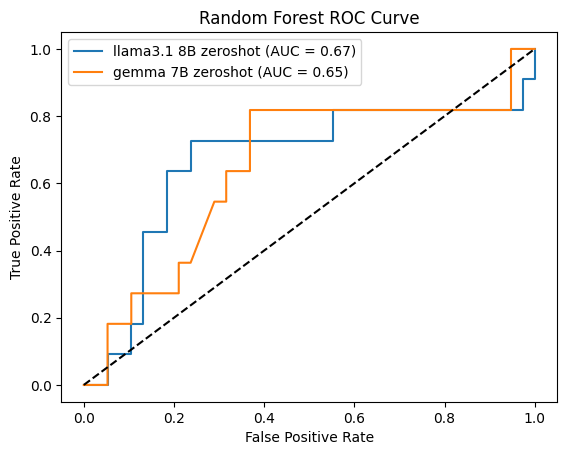

In [ ]:
roc1 = rf_roc("/Users/qzhang333/Desktop/Github/LLM-Microbiome/analysis/llama3_mars_zeroshot_embeddings.csv")
roc2 = rf_roc("/Users/qzhang333/Desktop/Github/LLM-Microbiome/analysis/gemma_mars_zeroshot_embeddings.csv")

# Plot
plt.figure()
plt.plot(roc1[0], roc1[1], label=f'llama3.1 8B zeroshot (AUC = {roc1[2]:.2f})')
plt.plot(roc2[0], roc2[1], label=f'gemma 7B zeroshot (AUC = {roc2[2]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.grid(False)
plt.show()